In [ ]:
  !curl -s https://course.fast.ai/setup/colab | bash

bash: line 1: syntax error near unexpected token `newline'
bash: line 1: `<!DOCTYPE html>'


In [ ]:
from google.colab import drive
from fastai.imports import *
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/dev/"
base_dir = root_dir + 'nn-sero-pytorch/'
path = Path(base_dir)

Mounted at /content/gdrive


['10a', '11a', '1a', '23a', '24a', '25a', '26a', '28a', '29a', '2a', '30a', '31a', '32a', '33a', '34a', '36a', '3a', '43a', '66a', '68a', '69a', '74a', '80a', '9a']


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.75E-02
Min loss divided by 10: 3.63E-02


epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.520468,4.614232,0.809295,0.058081,00:00
1,0.388288,0.249577,0.967949,0.754655,00:00
2,0.307094,0.348561,0.945513,0.632784,00:00
3,0.258510,0.113352,0.979167,0.653465,00:00
4,0.222016,0.033795,0.958333,0.846154,00:00
5,0.199516,0.058481,0.959936,0.771062,00:00
6,0.175397,0.035819,0.959936,0.820513,00:00
7,0.157508,0.028667,0.987180,0.852564,00:00
8,0.143184,0.022052,0.961538,0.948718,00:00
9,0.131551,0.025510,0.988782,0.884615,00:00


  0%|          | 1/1692 [00:00<03:21,  8.40it/s]

['10a', '11a', '1a', '23a', '24a', '25a', '26a', '28a', '29a', '2a', '30a', '31a', '32a', '33a', '34a', '36a', '3a', '43a', '66a', '68a', '69a', '74a', '80a', '9a']


100%|██████████| 1692/1692 [03:12<00:00,  8.80it/s]


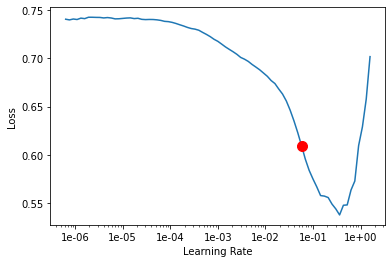

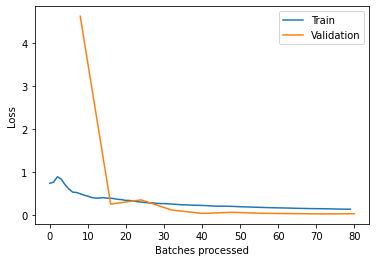

In [ ]:
import pandas as pd
import numpy as np
from fastai import *
from fastai.tabular import *
#from parse import _file_handler
from tqdm import tqdm

#below function directly from Andrew Chang in fast.ai forums (https://forums.fast.ai/t/automated-learning-rate-suggester/44199)
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

# _file_handler()

#loci = ['A', 'B', 'C', 'DPB1', 'DQB1', 'DRB1']
loci = ["A"]
epoch = { "A":10, "B":15, "C":15, "DPB1":10, "DQB1":10, "DRB1":15 }

for locus in loci:
  AAs = []
  tng_df = pd.read_csv(base_dir + 'RSNNS_fixed/training/' + locus + '_train.csv')
  tst_df = pd.read_csv(base_dir + 'RSNNS_fixed/testing/' + locus + '_test.csv')
  val_df = pd.read_csv(base_dir + 'RSNNS_fixed/training/' + locus + '_validation.csv')
  tng_idx = len(tng_df)
  val_idx = len(val_df) + 1
  tst_idx = len(tst_df)
  tbatch = tng_idx // 4
  if (tbatch <= 1):
    tbatch = tng_idx // 2
  vbatch = val_idx // 4
  if (vbatch <= 1):
    vbatch = val_idx // 2
  
  df = tng_df.append(val_df)

  for each in tng_df:
    if (each != 'allele') & (each != 'serology'):
      AAs.append(each)

  dep_var = 'serology'
  cat_names = ['allele'] + AAs
  procs = [FillMissing, Categorify]


  cat_names = ['allele'] + AAs
  test = TabularList.from_df(tst_df, path=Path(''), cat_names=cat_names)
  data = (TabularList.from_df(df=df, path=Path(''), procs=procs, cat_names=cat_names)
                              .split_by_idx(list(range(tng_idx,val_idx)))
                              .label_from_df(cols=dep_var, label_delim=';')
                              .add_test(test)
                              .databunch(bs=tbatch, val_bs=vbatch))
                            


  acc_02 = partial(accuracy_thresh, thresh=0.99)
  f_score = partial(fbeta, thresh=0.2)

  learn = tabular_learner(data, layers=[200,150], metrics=[acc_02, f_score])
  print(data.classes)

  lr = find_appropriate_lr(model=learn)
  learn.recorder.plot(suggestion=True)

  learn.fit(epoch[locus], lr=lr)

  learn.model
  learn.recorder.plot_losses()

  test_id = list(tst_df['allele'])

  classes = data.classes
  predictions = []
  print(classes)

  for i in tqdm(range(0,tst_idx)):
    category = str(learn.predict(tst_df.iloc[i], thresh=0.40)[0])
    sero = category.strip('MultiCategory ')
    sero = sero.replace(';',' ')
    sero = sero.replace('a','')
    predictions.append(sero.split())


  # below code involved help from some website using fast.ai to demonstrate kaggle solutions
  output_preds = pd.DataFrame({'allele': test_id, 'serology': predictions})
  output_preds.to_csv(base_dir + 'predictions/' + locus + '_predictions.csv', index=False)


In [ ]:
loci = ['A', 'B', 'C', 'DPB1', 'DRB1', 'DQB1']

comparison = open("compfile.txt", "w+")
newsies = open("newsies.txt", "w+")
similarities = open("similar.txt", "w+")

# function to check if value can be an integer - to eliminate excess characters from serology labels
def checkInt(x):
    print(x)
    try:
        int(x)
        return True
    except ValueError:
        return False

# function to eliminate any serological assignments with under a 95% likelihood
def chance(x, line):
    if (line[x].find("%") != -1):
        x = float(line[x][:-1])
        if 51 <= x:
            test = True
        else:
            test = False
    else:
        test = False
    return test

for loc in loci:
    oldPredict = {}
    newPredict = {}
    oldPredFile = "./old-predictions/" + loc + ".chile"
    newPreds = pd.read_csv("./predictions/" + loc + "_predictions.csv")
    newPreds = newPreds.set_index('allele')
    newPreds = newPreds.to_dict()
    newPredict = newPreds["serology"]
    for nKey in newPredict.keys():
        adjustMe = newPredict[nKey]
        adjustMe = adjustMe.replace('[','')
        adjustMe = adjustMe.replace(']','')
        adjustMe = adjustMe.replace(' ','')
        adjustMe = adjustMe.replace("'",'')
        adjustMe = adjustMe.split(',')
        newPredict[nKey] = [x.strip('a') for x in adjustMe if checkInt(x)]
        print(newPredict[nKey])
    with open(oldPredFile, "r") as handle:
        for line in handle:
            if line.find('%') == -1:
                next
            else:
                line = handle.readline()
                line = line.split()
                if line == []:
                    next
                else:
                    line[:] = [x for x in line if x != '[100.00%]']
                    allele = loc + "*" + str(line[0][:-1])
                    oldPredict[allele] = line[1:]

    for each in oldPredict.keys():
        if each not in newPredict.keys():
            print(each)
            next
        elif set(newPredict[each]) != set(oldPredict[each]):
            comparison.write("Different: " + str(each) + "\n")
            comparison.write("Old Serologic Assignment: " + str(oldPredict[each]) + "\n")
            comparison.write("New Serologic Assignment: " + str(newPredict[each]) + "\n")
        elif set(newPredict[each]) == set(oldPredict[each]):
            similarities.write("Same: " + str(each) + "\n")
            similarities.write("Old Serologic Assignment: " + str(oldPredict[each]) + "\n")
            similarities.write("New Serologic Assignment: " + str(newPredict[each]) + "\n")

    for allele in newPredict.keys():
        if allele not in oldPredict.keys():
            newsies.write("NEW: " + str(allele) + "\n")
            newsies.write("Serologic Assignment: " + str(newPredict[allele]) + "\n")